In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['HF_HOME'] = '/workspace'
print("HF_HOME is set to:", os.getenv('HF_HOME'))

HF_HOME is set to: /workspace


In [2]:
import psutil
import torch

def get_memory_info():
    # Get RAM usage
    ram = psutil.virtual_memory()
    print(f"Total RAM: {ram.total / (1024 ** 3):.2f} GB")
    print(f"Available RAM: {ram.available / (1024 ** 3):.2f} GB")
    print(f"Used RAM: {ram.used / (1024 ** 3):.2f} GB")
    print(f"RAM Usage: {ram.percent}%\n")
    
    # Get Swap memory usage
    swap = psutil.swap_memory()
    print(f"Total Swap: {swap.total / (1024 ** 3):.2f} GB")
    print(f"Used Swap: {swap.used / (1024 ** 3):.2f} GB")
    print(f"Free Swap: {swap.free / (1024 ** 3):.2f} GB")
    print(f"Swap Usage: {swap.percent}%\n")

def get_gpu_info():
    if torch.cuda.is_available():
        gpu_count = torch.cuda.device_count()
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
            print(f"Total GPU Memory: {torch.cuda.get_device_properties(i).total_memory / (1024 ** 3):.2f} GB")
            print(f"Allocated GPU Memory: {torch.cuda.memory_allocated(i) / (1024 ** 3):.2f} GB")
            print(f"Cached GPU Memory: {torch.cuda.memory_reserved(i) / (1024 ** 3):.2f} GB\n")
    else:
        print("No GPU available.\n")

def get_cache_info():
    # Clear the CUDA cache and print GPU memory info again
    if torch.cuda.is_available():
        print("Clearing CUDA cache...\n")
        torch.cuda.empty_cache()
        get_gpu_info()

if __name__ == "__main__":
    print("RAM and Memory Info:")
    get_memory_info()
    
    print("GPU Info:")
    get_gpu_info()
    
    print("Cache Info:")
    get_cache_info()


RAM and Memory Info:
Total RAM: 2015.55 GB
Available RAM: 1899.99 GB
Used RAM: 97.35 GB
RAM Usage: 5.7%

Total Swap: 18.00 GB
Used Swap: 4.94 GB
Free Swap: 13.06 GB
Swap Usage: 27.4%

GPU Info:
GPU 0: NVIDIA H100 PCIe MIG 3g.40gb
Total GPU Memory: 39.38 GB
Allocated GPU Memory: 0.00 GB
Cached GPU Memory: 0.00 GB

Cache Info:
Clearing CUDA cache...

GPU 0: NVIDIA H100 PCIe MIG 3g.40gb
Total GPU Memory: 39.38 GB
Allocated GPU Memory: 0.00 GB
Cached GPU Memory: 0.00 GB



In [3]:
from datasets import load_dataset

ds = load_dataset("ruslanmv/ai-medical-chatbot")

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['Description', 'Patient', 'Doctor'],
        num_rows: 256916
    })
})

In [5]:
# Display the first few rows of the training dataset
len(ds['train']['Patient'])


256916

In [6]:
# Check the data types of the features
print(ds['train'].features)


{'Description': Value(dtype='string', id=None), 'Patient': Value(dtype='string', id=None), 'Doctor': Value(dtype='string', id=None)}


In [7]:
# Check for missing values in each column
print("Missing values in 'Description':", sum([x is None for x in ds['train']['Description']]))
print("Missing values in 'Patient':", sum([x is None for x in ds['train']['Patient']]))
print("Missing values in 'Doctor':", sum([x is None for x in ds['train']['Doctor']]))


Missing values in 'Description': 0
Missing values in 'Patient': 0
Missing values in 'Doctor': 0


# basic statistical analysis

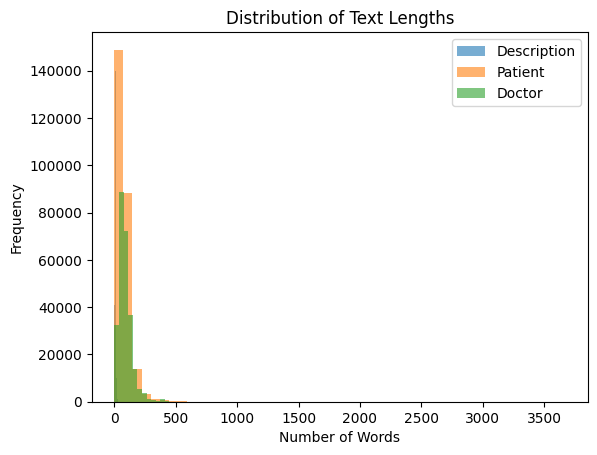

In [8]:
import matplotlib.pyplot as plt

# Calculate the length of text in each label
description_lengths = [len(x.split()) for x in ds['train']['Description']]
patient_lengths = [len(x.split()) for x in ds['train']['Patient']]
doctor_lengths = [len(x.split()) for x in ds['train']['Doctor']]

# Plot histograms
plt.hist(description_lengths, bins=50, alpha=0.6, label='Description')
plt.hist(patient_lengths, bins=50, alpha=0.6, label='Patient')
plt.hist(doctor_lengths, bins=50, alpha=0.6, label='Doctor')
plt.legend()
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


wordcloud for description

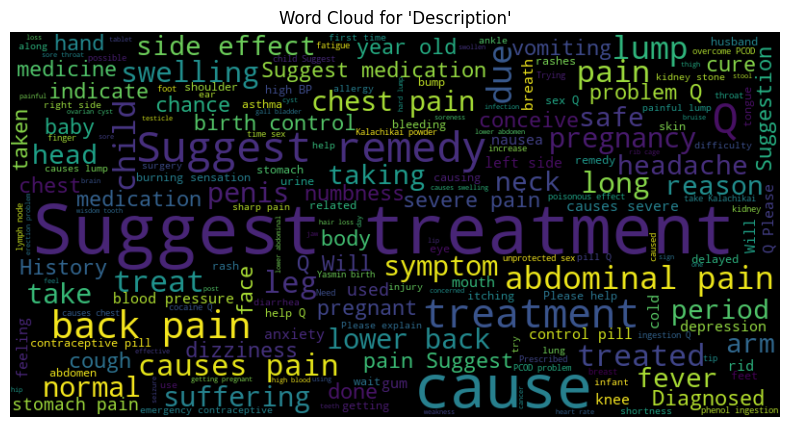

In [9]:
from wordcloud import WordCloud

# Generate word cloud for 'Description'
description_text = " ".join(ds['train']['Description'])
wordcloud = WordCloud(width=800, height=400).generate(description_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Description'")
plt.show()




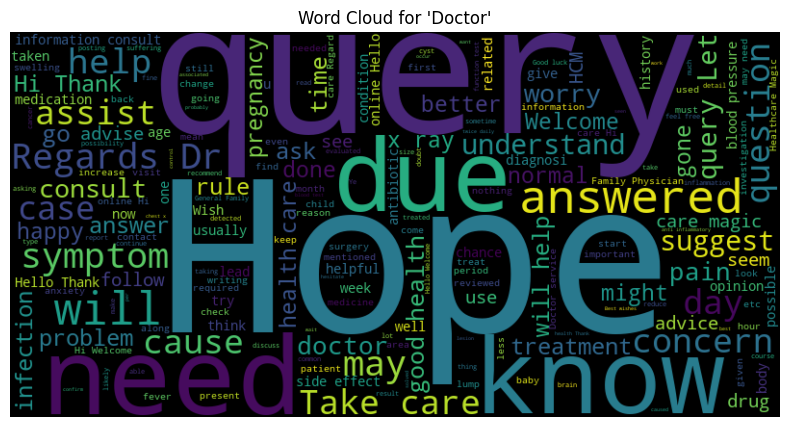

In [10]:
from wordcloud import WordCloud

# Generate word cloud for 'Description'
description_text = " ".join(ds['train']['Doctor'])
wordcloud = WordCloud(width=800, height=400).generate(description_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Doctor'")
plt.show()




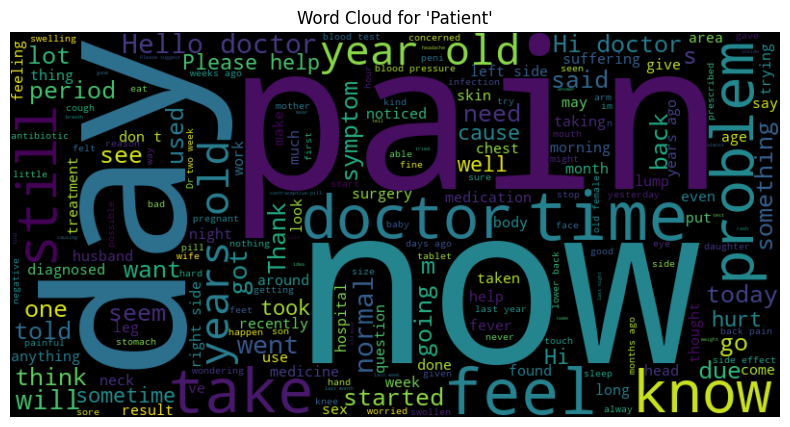

In [11]:
from wordcloud import WordCloud

# Generate word cloud for 'Description'
description_text = " ".join(ds['train']['Patient'])
wordcloud = WordCloud(width=800, height=400).generate(description_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for 'Patient'")
plt.show()

In [12]:
# Example: Count common words between 'Patient' and 'Doctor'
from collections import Counter

patient_words = Counter(" ".join(ds['train']['Patient']).split())
doctor_words = Counter(" ".join(ds['train']['Doctor']).split())

# Find common words
common_words = patient_words & doctor_words
print(common_words.most_common(10))


[('and', 598726), ('the', 522836), ('to', 448963), ('a', 348451), ('is', 329760), ('of', 297081), ('I', 261084), ('in', 251186), ('have', 226162), ('for', 210255)]


In [13]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# Load the dataset
ds = load_dataset("ruslanmv/ai-medical-chatbot")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct", trust_remote_code=True)

# Load the model in float16 precision
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out

In [14]:
import torch

def count_parameters_and_memory(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_memory = sum(p.numel() * p.element_size() for p in model.parameters() if p.requires_grad)
    return total_params, total_memory

def format_memory_size(bytes_size):
    # Convert bytes to MB or GB
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if bytes_size < 1024:
            return f"{bytes_size:.2f} {unit}"
        bytes_size /= 1024

# Assuming 'model' is the variable holding your LLM
model_parameters, model_memory = count_parameters_and_memory(model)
formatted_memory = format_memory_size(model_memory)

print(f"The model has {model_parameters:,} parameters.")
print(f"The model is taking approximately {formatted_memory} of memory.")

The model has 3,821,079,552 parameters.
The model is taking approximately 7.12 GB of memory.


model takes 7.12 GB of memory in less precision

In [15]:
# Example: Select a random patient input from the dataset
patient_input = ds['train']['Patient'][0]
print("Patient Input:", patient_input)

# Prepare the input for the model
input_text = f"Patient: {patient_input}\nDoctor:"

# Create a pipeline for text generation
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Generate Doctor's response using max_new_tokens
doctor_output = text_generator(input_text, max_new_tokens=50, do_sample=True, num_return_sequences=1)
print("Generated Doctor Output:", doctor_output[0]['generated_text'])

# Prepare the input for the Description based on the patient and doctor's interaction
input_text_for_description = f"Patient: {patient_input}\nDoctor: {doctor_output[0]['generated_text']}\nDescription:"

# Generate Description using max_new_tokens
description_output = text_generator(input_text_for_description, max_new_tokens=50, do_sample=True, num_return_sequences=1)
print("Generated Description Output:", description_output[0]['generated_text'])


Patient Input: Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?


The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
You are not running the flash-attention implementation, expect numerical differences.


Generated Doctor Output: Patient: Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?
Doctor: Hello! I'd be glad to explain the terms you mentioned and discuss potential treatments for an annular bulge and tear in the spinal nerve root, which is often referred to as a herniated disc.

**
Generated Description Output: Patient: Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?
Doctor: Patient: Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?
Doctor: Hello! I'd be glad to explain the terms you mentioned and discuss potential treatments for an annular bulge and tear in the spinal nerve root, which is often referred to as a he

# testing tokenizer

In [16]:
# Sample text
sample_text = "I have a headache and feel dizzy."

# Tokenize the sample text
tokens = tokenizer.tokenize(sample_text)
print("Tokens:", tokens)

# Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", token_ids)

# Encode the text (this gives you both token IDs and attention mask)
encoded_input = tokenizer(sample_text, padding='max_length', max_length=10, truncation=True)
print("Encoded Input:", encoded_input)

# Decode the token IDs back to text
decoded_text = tokenizer.decode(token_ids)
print("Decoded Text:", decoded_text)


Tokens: ['▁I', '▁have', '▁a', '▁head', 'ache', '▁and', '▁feel', '▁d', 'iz', 'zy', '.']
Token IDs: [306, 505, 263, 2343, 1829, 322, 4459, 270, 466, 1537, 29889]
Encoded Input: {'input_ids': [306, 505, 263, 2343, 1829, 322, 4459, 270, 466, 1537], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Decoded Text: I have a headache and feel dizzy.


In [17]:
# Initialize variables to store maximum token lengths
max_tokens_patient = 0
max_tokens_description = 0
max_tokens_doctor = 0

# Iterate through the dataset to find the maximum token lengths
for example in ds['train']:
    patient_tokens = tokenizer(example['Patient'])['input_ids']
    description_tokens = tokenizer(example['Description'])['input_ids']
    doctor_tokens = tokenizer(example['Doctor'])['input_ids']
    
    max_tokens_patient = max(max_tokens_patient, len(patient_tokens))
    max_tokens_description = max(max_tokens_description, len(description_tokens))
    max_tokens_doctor = max(max_tokens_doctor, len(doctor_tokens))

# Print the results
print("Maximum number of tokens in Patient:", max_tokens_patient)
print("Maximum number of tokens in Description:", max_tokens_description)
print("Maximum number of tokens in Doctor:", max_tokens_doctor)


Maximum number of tokens in Patient: 4491
Maximum number of tokens in Description: 382
Maximum number of tokens in Doctor: 2842


In [18]:
# Print the dataset's first entry to check its structure
print(ds['train'][0])


{'Description': 'Q. What does abutment of the nerve root mean?', 'Patient': 'Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for\xa0annular bulging and tear?', 'Doctor': 'Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online -->'}


In [19]:
import torch
from datasets import DatasetDict  # Import DatasetDict
from transformers import Trainer, TrainingArguments

# Define your function as before
def process_data_with_sliding_window(examples, stride=256):
    inputs = examples['Patient']
    targets = [f"Doctor: {doctor}\nDescription: {description}" for doctor, description in zip(examples['Doctor'], examples['Description'])]
    
    # Maximum input and output lengths
    max_length = 1024  # Adjust as needed, but ensure it fits within your GPU memory constraints
    stride = max_length // 2  # Adjust stride to overlap windows if needed

    # Tokenize with a sliding window
    model_inputs = {'input_ids': [], 'attention_mask': [], 'labels': []}
    
    for input_text, target_text in zip(inputs, targets):
        input_tokens = tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True).input_ids.squeeze()
        target_tokens = tokenizer(target_text, return_tensors="pt", max_length=max_length, truncation=True).input_ids.squeeze()

        # Ensure tensors are at least 1-dimensional
        if input_tokens.dim() == 0:
            input_tokens = input_tokens.unsqueeze(0)
        if target_tokens.dim() == 0:
            target_tokens = target_tokens.unsqueeze(0)

        # Create sliding windows for inputs
        for i in range(0, len(input_tokens), stride):
            input_slice = input_tokens[i:i + max_length]
            target_slice = target_tokens[i:i + max_length]

            # Padding the slices if they are smaller than max_length
            if len(input_slice) < max_length:
                padding_length = max_length - len(input_slice)
                input_slice = torch.cat([input_slice, torch.zeros(padding_length, dtype=torch.long)])
            if len(target_slice) < max_length:
                padding_length = max_length - len(target_slice)
                target_slice = torch.cat([target_slice, torch.zeros(padding_length, dtype=torch.long)])

            model_inputs['input_ids'].append(input_slice)
            model_inputs['attention_mask'].append(torch.ones_like(input_slice))
            model_inputs['labels'].append(target_slice)
    
    # Convert lists to tensors and return as a dictionary
    model_inputs['input_ids'] = torch.stack(model_inputs['input_ids'])
    model_inputs['attention_mask'] = torch.stack(model_inputs['attention_mask'])
    model_inputs['labels'] = torch.stack(model_inputs['labels'])

    return model_inputs

tokenized_datasets = ds.map(process_data_with_sliding_window, batched=True, remove_columns=['Patient', 'Doctor', 'Description'])

# Continue with your original dataset split and training code
train_test_split = tokenized_datasets['train'].train_test_split(test_size=0.1)

# Use DatasetDict to recreate the train/validation split
train_test_split = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test'],
})

# Continue with data collator, training arguments, and model training as before


In [20]:
print("Sample from training set:", train_test_split['train'][0])
print("Sample from validation set:", train_test_split['validation'][0])


Sample from training set: {'input_ids': [1619, 8750, 756, 24554, 310, 2319, 2586, 267, 373, 902, 10188, 322, 6567, 508, 445, 367, 515, 6592, 6152, 29879, 29973, 2296, 4083, 896, 526, 372, 23766, 322, 443, 510, 3921, 519, 29889, 1576, 2586, 267, 2615, 363, 263, 8000, 29892, 885, 370, 322, 2041, 1250, 29889, 1619, 28056, 884, 756, 263, 2846, 289, 568, 373, 902, 1250, 322, 22827, 29889, 2216, 1854, 565, 306, 881, 298, 533, 263, 282, 342, 2761, 2022, 1363, 306, 626, 15041, 1048, 773, 4023, 845, 22233, 29879, 29973, 1815, 366, 1371, 411, 738, 2472, 1048, 590, 4828, 29973, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [21]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments, AutoModelForCausalLM
# Create a data collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Set to False because we're not using masked language modeling
)


In [22]:
# Print the model architecture to find suitable target modules
for name, param in model.named_parameters():
    print(name)


model.embed_tokens.weight
model.layers.0.self_attn.o_proj.weight
model.layers.0.self_attn.qkv_proj.weight
model.layers.0.mlp.gate_up_proj.weight
model.layers.0.mlp.down_proj.weight
model.layers.0.input_layernorm.weight
model.layers.0.post_attention_layernorm.weight
model.layers.1.self_attn.o_proj.weight
model.layers.1.self_attn.qkv_proj.weight
model.layers.1.mlp.gate_up_proj.weight
model.layers.1.mlp.down_proj.weight
model.layers.1.input_layernorm.weight
model.layers.1.post_attention_layernorm.weight
model.layers.2.self_attn.o_proj.weight
model.layers.2.self_attn.qkv_proj.weight
model.layers.2.mlp.gate_up_proj.weight
model.layers.2.mlp.down_proj.weight
model.layers.2.input_layernorm.weight
model.layers.2.post_attention_layernorm.weight
model.layers.3.self_attn.o_proj.weight
model.layers.3.self_attn.qkv_proj.weight
model.layers.3.mlp.gate_up_proj.weight
model.layers.3.mlp.down_proj.weight
model.layers.3.input_layernorm.weight
model.layers.3.post_attention_layernorm.weight
model.layers.4

In [23]:
# from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# import torch
# from peft import LoraConfig, get_peft_model

# # Define LoRA configuration
# lora_config = LoraConfig(
#     r=8,  # Low rank
#     lora_alpha=32,  # Scaling parameter
#     target_modules=[
#         "self_attn.qkv_proj",  # Targeting query, key, value projections in attention
#         "self_attn.o_proj",    # Targeting output projection in attention
#         "mlp.gate_up_proj",    # Targeting gate-up projection in MLP
#         "mlp.down_proj"        # Targeting down projection in MLP
#     ],
#     lora_dropout=0.1,
#     bias="none"
# )

# # Apply LoRA to the model
# model = get_peft_model(model, lora_config)

# # Move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)


In [24]:
import torch

def count_parameters_and_memory(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_memory = sum(p.numel() * p.element_size() for p in model.parameters() if p.requires_grad)
    return total_params, total_memory

def format_memory_size(bytes_size):
    # Convert bytes to MB or GB
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if bytes_size < 1024:
            return f"{bytes_size:.2f} {unit}"
        bytes_size /= 1024

# Assuming 'model' is the variable holding your LLM
model_parameters, model_memory = count_parameters_and_memory(model)
formatted_memory = format_memory_size(model_memory)

print(f"The model has {model_parameters:,} parameters.")
print(f"The model is taking approximately {formatted_memory} of memory.")

The model has 3,821,079,552 parameters.
The model is taking approximately 7.12 GB of memory.


In [26]:
import torch
from datasets import DatasetDict
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq, AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

# Load the dataset
ds = load_dataset("ruslanmv/ai-medical-chatbot")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct", trust_remote_code=True)

# Load the model in float16 precision
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define LoRA configuration
lora_config = LoraConfig(
    r=8,  # Low rank
    lora_alpha=32,  # Scaling parameter
    target_modules=[
        "self_attn.qkv_proj",  # Targeting query, key, value projections in attention
        "self_attn.o_proj",    # Targeting output projection in attention
        "mlp.gate_up_proj",    # Targeting gate-up projection in MLP
        "mlp.down_proj"        # Targeting down projection in MLP
    ],
    lora_dropout=0.1,
    bias="none"
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Define your function for sliding window tokenization
def process_data_with_sliding_window(examples, stride=256):
    inputs = examples['Patient']
    targets = [f"Doctor: {doctor}\nDescription: {description}" for doctor, description in zip(examples['Doctor'], examples['Description'])]
    
    max_length = 1024
    stride = max_length // 2

    model_inputs = {'input_ids': [], 'attention_mask': [], 'labels': []}
    
    for input_text, target_text in zip(inputs, targets):
        input_tokens = tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True).input_ids.squeeze()
        target_tokens = tokenizer(target_text, return_tensors="pt", max_length=max_length, truncation=True).input_ids.squeeze()

        if input_tokens.dim() == 0:
            input_tokens = input_tokens.unsqueeze(0)
        if target_tokens.dim() == 0:
            target_tokens = target_tokens.unsqueeze(0)

        for i in range(0, len(input_tokens), stride):
            input_slice = input_tokens[i:i + max_length]
            target_slice = target_tokens[i:i + max_length]

            if len(input_slice) < max_length:
                padding_length = max_length - len(input_slice)
                input_slice = torch.cat([input_slice, torch.zeros(padding_length, dtype=torch.long)])
            if len(target_slice) < max_length:
                padding_length = max_length - len(target_slice)
                target_slice = torch.cat([target_slice, torch.zeros(padding_length, dtype=torch.long)])

            model_inputs['input_ids'].append(input_slice)
            model_inputs['attention_mask'].append(torch.ones_like(input_slice))
            model_inputs['labels'].append(target_slice)
    
    model_inputs['input_ids'] = torch.stack(model_inputs['input_ids'])
    model_inputs['attention_mask'] = torch.stack(model_inputs['attention_mask'])
    model_inputs['labels'] = torch.stack(model_inputs['labels'])

    return model_inputs

# Tokenize the dataset
tokenized_datasets = ds.map(process_data_with_sliding_window, batched=True, remove_columns=['Patient', 'Doctor', 'Description'])

# Continue with your original dataset split and training code
train_test_split = tokenized_datasets['train'].train_test_split(test_size=0.1)

# Use DatasetDict to recreate the train/validation split
train_test_split = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test'],
})

# Define the data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,  # Reduced gradient accumulation steps to reduce the number of updates per epoch
    num_train_epochs=1,  # Reduce epochs to 1
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    fp16=True,
    push_to_hub=False,
    remove_unused_columns=False,
    max_grad_norm=1.0,
    dataloader_num_workers=2,
    dataloader_pin_memory=True
)

train_dataset = train_test_split['train'].select(range(1500))

# Initialize the Trainer with the limited training dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_test_split['validation'].select(range(100)),# Use only 15k samples
 # You can also limit validation set if needed
    data_collator=data_collator
)

trainer.train()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/llm_bootcamp/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/envs/llm_bootcamp/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_

Epoch,Training Loss,Validation Loss
0,No log,No log


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)


TrainOutput(global_step=187, training_loss=1.3888017787015374, metrics={'train_runtime': 560.5698, 'train_samples_per_second': 2.676, 'train_steps_per_second': 0.334, 'total_flos': 3.4331456327122944e+16, 'train_loss': 1.3888017787015374, 'epoch': 0.9973333333333333})

**i have fine tuned model on less data so that there are some issues with results. complete data required 76 hours of training. otherwise project is a complete pipeline of how we can fine tune the model